# Conjugate Gradient Method

Gabriel Konar-Steenberg, 2022-10-24

## Problem Statement

"For a convex optimization problem with a cost function to minimize:
$$ f(x, y, z) = a(x-1)^4+(y-2)^2+b(z-1)^4 $$
choose your own parameter values $a > 0, b > 0$ and use $(2, 3, 2)$… as a start point for your iterations.… [W]rite… code for the conjugate gradient method, output a plot that illustrates a convergence toward the analytical result…."

## Solution

We use the Polack-Ribière conjugage gradient algorithm as presented in Sébastien Bubeck, "Convex Optimization, Algorithms and Complexity." We will prioritize readability over performance.

As usual, we begin by defining the parameters and some helper apparatus. We let $a = 2, b = 3$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters of the problem
# n = 3  # dimensionality
a = 2
b = 3
x0 = np.array([[2], [3], [2]])
answer = np.array([[1], [2], [1]])

def f(x):
    return (a*(x[0]-1)**4+(x[1]-2)**2+b*(x[2]-1)**4)

def grad(pt, delta = 1e-7):  # Returns an approximation of the gradient of f at a given point
    xs = (pt @ np.ones(pt.shape).T)  # Make n copies of x so we can perturb it in n dimensions
    xh = xs + np.eye(pt.shape[0])*delta  # Perturb along each dimension
    return ((f(xh)-f(xs))/delta).reshape(pt.shape)  # Calculate the slope and reshape to taste

def normalize(vec):
    vec = np.array(vec, "float")
    norm = np.linalg.norm(vec)
    return vec if norm == 0 else vec/norm

print(f(x0))
print(grad(x0))


[6]
[[ 8.00000119]
 [ 2.00000009]
 [12.00000177]]


The algorithm calls for a line search. Just for fun, let's make one up without consulting any resources. We'll start at the given point, figure out which direction to move in based on the gradient, extend a "feeler" exponentially in that direction until the gradient sign switches to obtain another bound, and then do a binary search to narrow those bounds to taste.

In [2]:
def line_grad(x, p):  # Component of the gradient parallel to p
    return (grad(x).T @ normalize(p))[0,0]

def my_line_search(x, p, feeler_init = 1e-3, feeler_step=2, tolerance=1e-7, max_iters=1000):
    la = 0
    lgla = line_grad(x, p)
    lb = -line_grad(x, p)*feeler_init
    # Part 1: Obtain a bound opposite from the one we have
    i = 0
    while lgla * line_grad(x+lb*p, p) > 0:  # We need one endpoint to have a positive gradient and one a negative <=> product is negative
        lb *= feeler_step
        i += 1
        if i >= max_iters: raise TimeoutError("Timed out in bounds expansion")
    lmax, lmin = max(la, lb), min(la, lb)
    # Part 2: Now we know that the true lambda is between lmin and lmax, so we can binary search
    i = 0
    while lmax-lmin > tolerance:
        lnew = (lmax+lmin)/2
        if line_grad(x+lnew*p, p) > 0: lmax = lnew
        else: lmin = lnew
        i += 1
        if i >= max_iters: raise TimeoutError("Timed out in binary search")
    return x+lnew*p

print(line_grad(my_line_search(x0, grad(x0)), grad(x0)))

7.799705841748938e-07


Now for the algorithm itself:

In [3]:
p0 = grad(x0)

def get_next_x(this_x, this_p):
    return my_line_search(this_x, this_p)

def get_next_p(this_x, next_x, this_p):
    numer = (grad(next_x)-grad(this_x)).T @ grad(next_x)
    denom = grad(this_x).T @ grad(this_x)
    return grad(next_x)+(numer/denom)*this_p

print(get_next_p(x0, get_next_x(x0, p0), p0))

[[ 0.11971635]
 [ 1.59571753]
 [-0.13344435]]


We should theoretically be done after $n=3$ iterations, but let's run the algorithm for 20 iterations just to see what happens:

           x         y         z     error
0   2.000000  3.000000  2.000000  1.732051
1   1.143363  2.785841  0.715044  0.848115
2   1.083999  1.994567  0.781215  0.234418
3   1.077896  2.010474  0.946080  0.095315
4   1.075811  1.999465  0.948893  0.091430
5   1.007811  2.000814  0.983250  0.018500
6   1.007299  1.999990  0.983536  0.018009
7   1.003172  2.000019  0.999391  0.003229
8   1.003166  2.000000  0.999412  0.003220
9   1.000231  2.000000  1.000296  0.000376
10  1.000231  2.000000  1.000296  0.000376
11  1.000111  2.000000  0.999933  0.000129
12  1.000111  2.000000  0.999933  0.000129
13  0.999979  2.000000  0.999972  0.000035
14  0.999979  2.000000  0.999972  0.000035
15  0.999988  2.000000  1.000006  0.000014
16  0.999988  2.000000  1.000006  0.000014
17  0.999988  2.000000  1.000007  0.000014
18  0.999988  2.000000  1.000007  0.000014
19  0.999988  2.000000  1.000007  0.000014


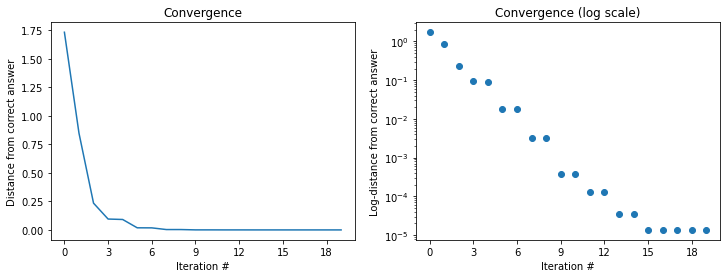

In [4]:
n_iters = 20
this_x, this_p = x0, p0
x_ts = [this_x]
p_ts = [this_p]
i = 1
while (i < n_iters):
    next_x = get_next_x(this_x, this_p)
    next_p = get_next_p(this_x, next_x, this_p)
    this_x, this_p = next_x, next_p
    x_ts.append(this_x)
    p_ts.append(this_p)
    i += 1

results = np.concatenate([np.array(x_ts)[:,:,0], np.linalg.norm(np.array(x_ts)-answer, axis=1)], axis=-1)
try:  # If you have pandas, let's use it to print prettily
    import pandas as pd
    print(pd.DataFrame(results, columns=["x", "y", "z", "error"]))
except ModuleNotFoundError:  # Otherwise, this is fine
    print("x, y, z, error:")
    print(results)

# Line plot of the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(list(range(n_iters)), np.linalg.norm(np.array(x_ts)-answer, axis=1))
axs[0].set_xticks(np.arange(0, n_iters+1, 3))
axs[0].set_ylabel("Distance from correct answer")
axs[0].set_xlabel("Iteration #")
axs[0].set_title("Convergence")

# Scatter plot of the results with a logarithmic y-axis
axs[1].scatter(list(range(n_iters)), np.linalg.norm(np.array(x_ts)-answer, axis=1))
axs[1].set_yscale("log")
axs[1].set_xticks(np.arange(0, n_iters+1, 3))
axs[1].set_ylabel("Log-distance from correct answer")
axs[1].set_xlabel("Iteration #")
axs[1].set_title("Convergence (log scale)")
plt.show()

Success! As Jonathan Richard Shewchuk, "An Introduction to the Conjugate Gradient Method Without the Agonizing Pain" explains, roundoff and cancellation error keep the theoretical result of convergence in $n$ iterations from being achieved in practice. However, we can achieve a reasonably good result by brute iteration. There is an interesting pattern visible in the log-convergence plot above, where after the initial three iterations it seems that the odd iterations make much more of an improvement than the even iterations.